In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
import logging

import numpy as np
import h5netcdf

import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd
from scipy.signal import convolve2d, detrend

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

plt.rc("figure", figsize=(12,10))
plt.rc("font", size=14)

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, silence_logs='error')
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45855 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:45855/status,
Dashboard: http://137.129.155.67:45855/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: inproc://137.129.155.67/58711/1,Workers: 1
Dashboard: http://137.129.155.67:45855/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: inproc://137.129.155.67/58711/4,Total threads: 4
Dashboard: http://137.129.155.67:39831/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
var = 'TCWV'
indir_data_RAW = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/TCWV/'
indir_data_FILTERED = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/TCWV/'
indir_data_FILTERED_VERIF = '/cnrm/tropics/user/peyrille/Stage_PFE_Erwan/data/ERAI/tcwv/'


var_file = 'anom_tcwv_brut_ERA5_3H'
var_file_verif = 'tcwv_anom_wkfilter_2009'

In [3]:
year = 2009
latitude = 10.5
longitude = 0.5
day1 = '2009-08-21'
day2 = '2009-09-20'

ds_RAW = xr.open_mfdataset(indir_data_RAW + '*' + var_file + '*' + str(year) + '.nc', chunks = {'time' : 1}, parallel=True)
ds_FILTER_1 = xr.open_mfdataset(indir_data_FILTERED + '*' + str(year) + '.nc', chunks = {'time' : 1}, parallel=True)
ds_FILTER_2 = xr.open_mfdataset(indir_data_FILTERED + '*' + str(year+1) + '.nc', chunks = {'time' : 1}, parallel=True)
ds_FILTER = xr.concat([ds_FILTER_1, ds_FILTER_2], dim = 'time')


ds_FILTER_VERIF = xr.open_mfdataset(indir_data_FILTERED_VERIF + var_file_verif + '.nc', chunks = {'time' : 1}, parallel=True)
ds_FILTER

<xarray.Dataset>
Dimensions:      (time: 5840, lat: 321, lon: 1440)
Coordinates:
  * time         (time) datetime64[ns] 2009-01-01 ... 2010-12-31T21:00:00
  * lat          (lat) float64 40.0 39.75 39.5 39.25 ... -39.5 -39.75 -40.0
  * lon          (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    TCWV_Kelvin  (time, lat, lon) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>
    TCWV_Rossby  (time, lat, lon) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>
    TCWV_MJO     (time, lat, lon) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>
    TCWV_MRG     (time, lat, lon) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>
    TCWV_EIG     (time, lat, lon) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>
    TCWV_WIG     (time, lat, lon) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>
    TCWV_TD      (time, lat, lon) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>
    TCWV_LF      (time, lat, lon) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>

In [4]:
da_TCWV_Kelvin = ds_FILTER[var + '_Kelvin']
da_TCWV_Rossby = ds_FILTER[var + '_Rossby']
da_TCWV_MJO = ds_FILTER[var + '_MJO']
da_TCWV_MRG = ds_FILTER[var + '_MRG']
da_TCWV_EIG = ds_FILTER[var + '_EIG']
da_TCWV_WIG = ds_FILTER[var + '_WIG']
da_TCWV_TD = ds_FILTER[var + '_TD']
da_TCWV_LF = ds_FILTER[var + '_LF'] 
da_TCWV_Rossby
da_TCWV_TD

<xarray.DataArray 'TCWV_Rossby' (time: 5840, lat: 321, lon: 1440)>
dask.array<concatenate, shape=(5840, 321, 1440), dtype=float64, chunksize=(1, 321, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2009-01-01 ... 2010-12-31T21:00:00
  * lat      (lat) float64 40.0 39.75 39.5 39.25 ... -39.25 -39.5 -39.75 -40.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    units:    kg/m^2
    tMin:     9.7
    tMax:     48.0
    kMin:     -10
    kMax:     -1
    hMin:     8
    hMax:     90

In [19]:
da_FILTER_TOT = da_TCWV_Kelvin + \
                da_TCWV_Rossby + \
                da_TCWV_MJO + \
                da_TCWV_MRG + \
                da_TCWV_EIG + \
                da_TCWV_WIG + \
                da_TCWV_TD*0 

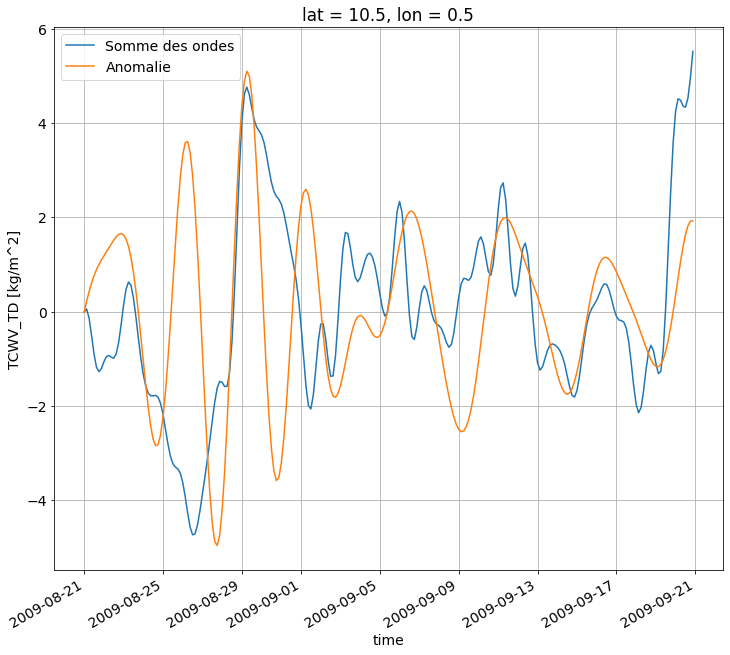

In [21]:
da_FILTER_TOT.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = ('Somme des ondes'))
da_TCWV_TD.sel(lat = latitude, lon = longitude).sel(time = slice(day1, day2)).plot(label = ('Anomalie'))
plt.legend()
plt.grid()

In [6]:
da_TCWV_Rossby_Verif = ds_FILTER_VERIF['er_wk']

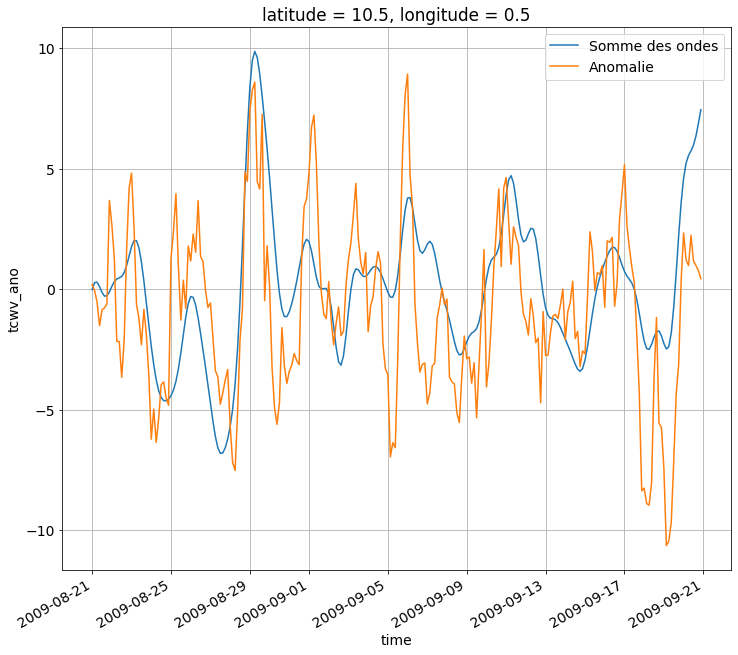

In [7]:
da_FILTER_TOT.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = ('Somme des ondes'))
ds_RAW['tcwv_ano'].sel(latitude = latitude, longitude = longitude).sel(time = slice(day1, day2)).plot(label = ('Anomalie'))
plt.legend()
plt.grid()

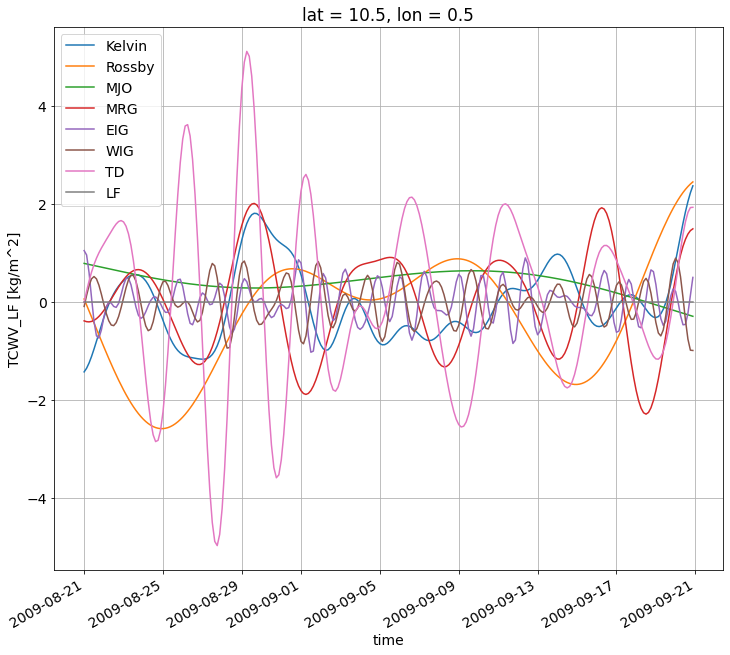

In [18]:
plt.rc("figure", figsize=(12,10))

da_TCWV_Kelvin.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = 'Kelvin')
da_TCWV_Rossby.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = 'Rossby')
da_TCWV_MJO.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = 'MJO')
da_TCWV_MRG.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = 'MRG')
da_TCWV_EIG.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = 'EIG')
da_TCWV_WIG.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = 'WIG')
da_TCWV_TD.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = 'TD')
da_TCWV_LF.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = 'LF')


# da_TCWV_Rossby_Verif.sel(lat = latitude, lon = longitude, method = 'nearest').sel(time = slice(day1, day2)).plot(label = 'Rossby PP')
plt.legend()
plt.grid()

In [9]:
_hov = ds_FILTER.sel(lat = 2.5, method = 'nearest').sel(time = slice(day1, day2))
ds_FILTER

<xarray.Dataset>
Dimensions:      (time: 5840, lat: 321, lon: 1440)
Coordinates:
  * time         (time) datetime64[ns] 2009-01-01 ... 2010-12-31T21:00:00
  * lat          (lat) float64 40.0 39.75 39.5 39.25 ... -39.5 -39.75 -40.0
  * lon          (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    TCWV_Kelvin  (time, lat, lon) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>
    TCWV_Rossby  (time, lat, lon) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>
    TCWV_MJO     (time, lat, lon) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>
    TCWV_MRG     (time, lat, lon) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>
    TCWV_EIG     (time, lat, lon) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>
    TCWV_WIG     (time, lat, lon) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>
    TCWV_TD      (time, lat, lon) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>
    TCWV_LF      (time, lat, lon) float64 dask.array<chunksize=(1, 321, 1440), meta=np.ndarray>

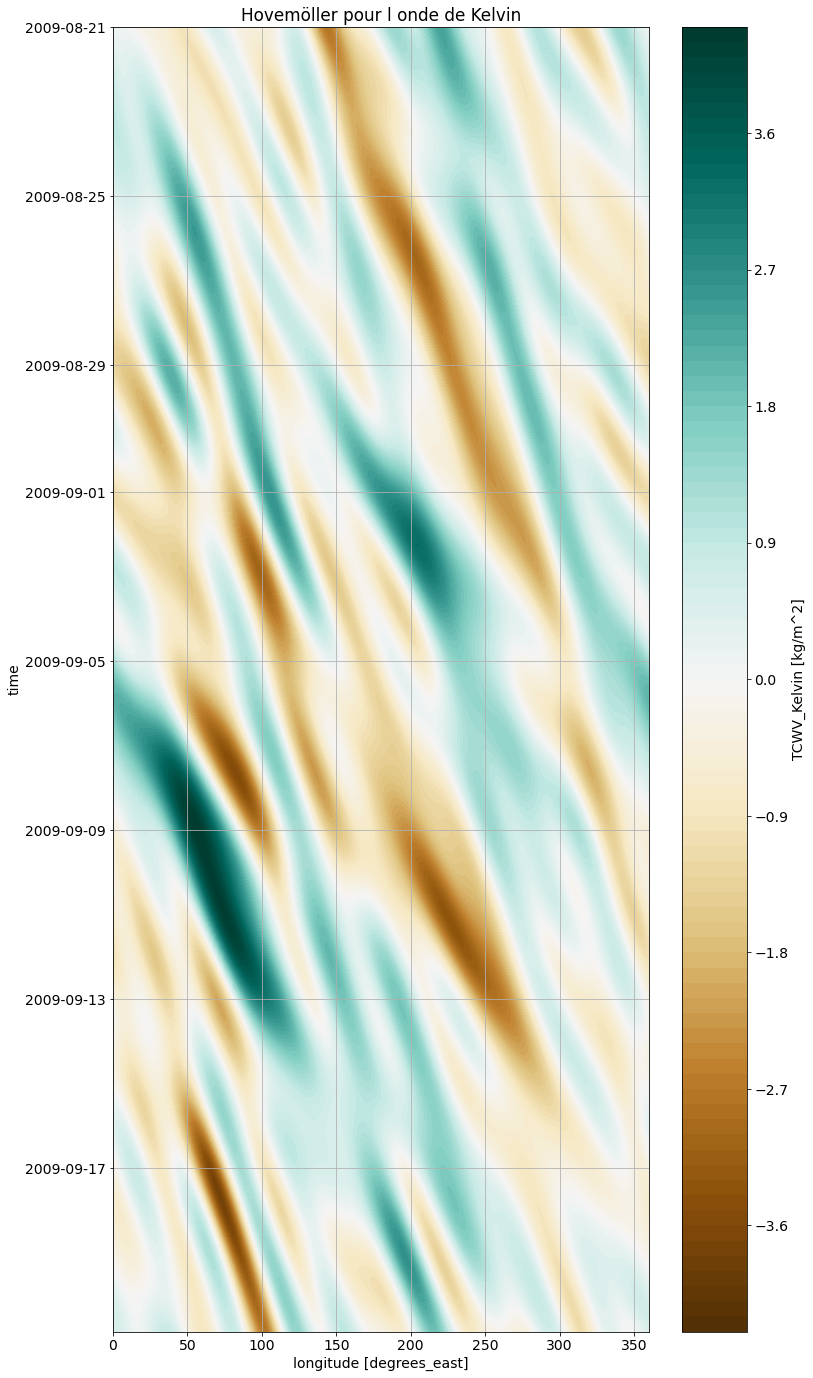

In [10]:
plt.rc("figure", figsize=(12,24))
_hov['TCWV_Kelvin'].plot.contourf(levels = 100, cmap = 'BrBG')
plt.gca().invert_yaxis()
plt.title('Hovemöller pour l onde de Kelvin')
plt.grid()

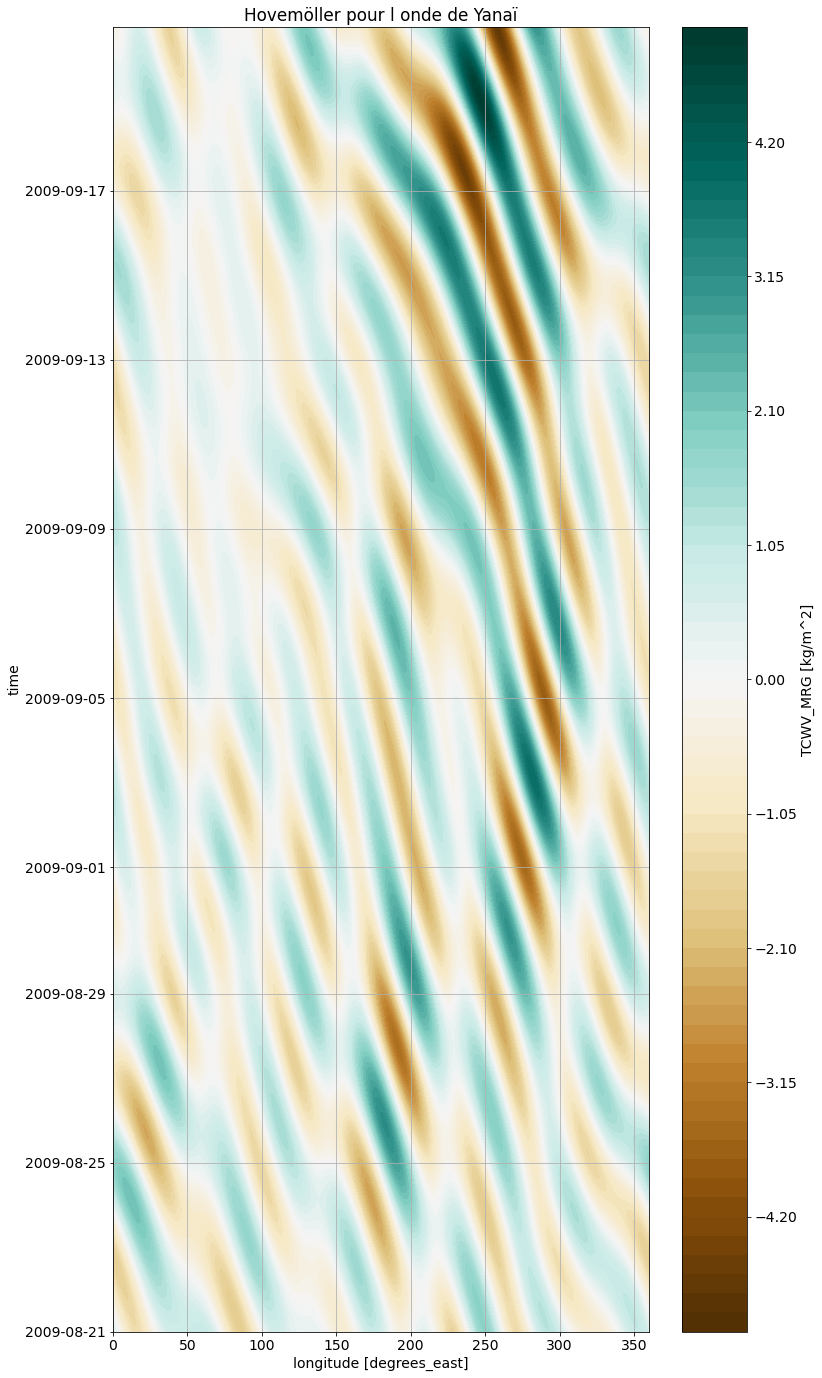

In [11]:
plt.rc("figure", figsize=(12,24))
_hov['TCWV_MRG'].plot.contourf(levels = 100, cmap = 'BrBG')
plt.title('Hovemöller pour l onde de Yanaï')
plt.grid()

In [12]:
_hov = ds_FILTER.sel(lat = slice(15,5)).sel(lon = slice(-10,10)).sel(time = '01-01-2009T12')


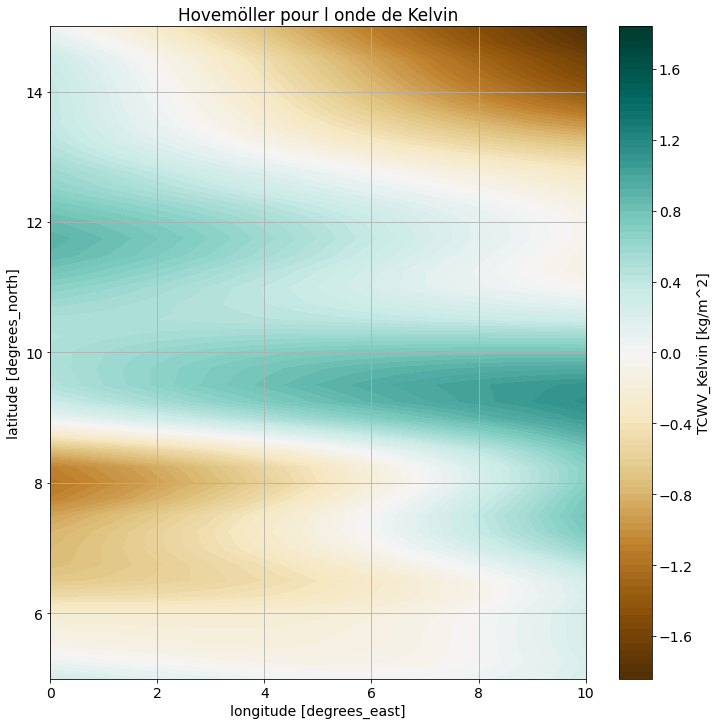

In [13]:
plt.rc("figure", figsize=(12,12))
_hov['TCWV_Kelvin'].plot.contourf(levels = 100, cmap = 'BrBG')
plt.title('Hovemöller pour l onde de Kelvin')
plt.grid()

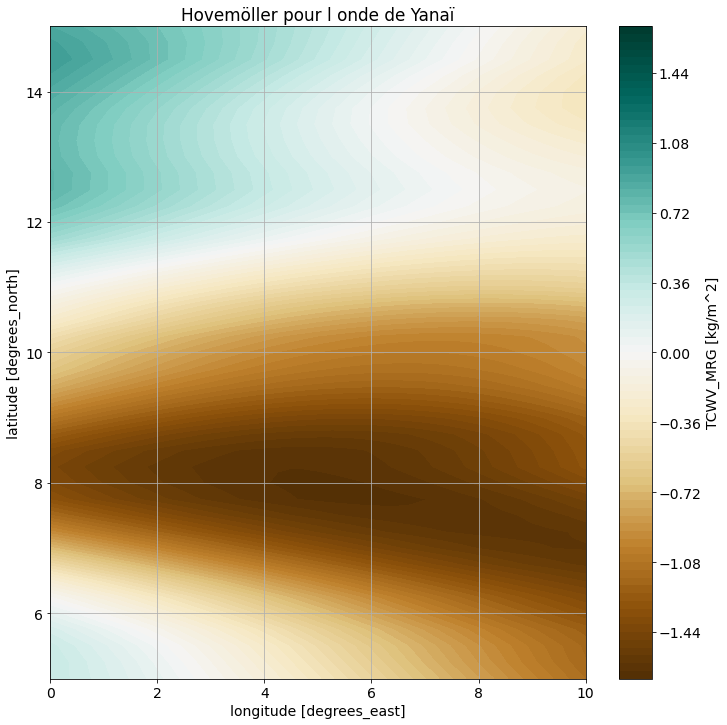

In [14]:
plt.rc("figure", figsize=(12,12))
_hov['TCWV_MRG'].plot.contourf(levels = 100, cmap = 'BrBG')
plt.title('Hovemöller pour l onde de Yanaï')
plt.grid()

In [15]:
_hov = ds_FILTER.sel(lat = slice(5,-5)).sel(lon = longitude, method = 'nearest')

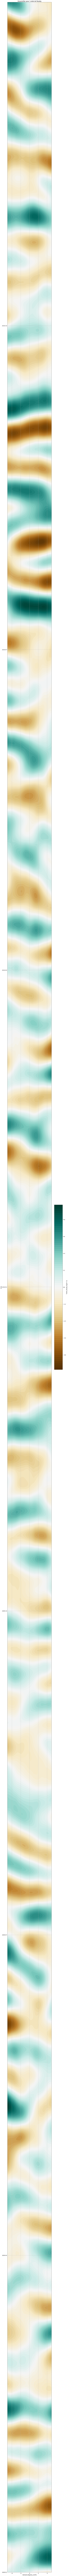

In [16]:

plt.rc("figure", figsize=(12,24*24))
_hov['TCWV_Rossby'].plot.contourf(levels = 100, cmap = 'BrBG')
plt.title('Hovemöller pour l onde de Rossby')
plt.grid()